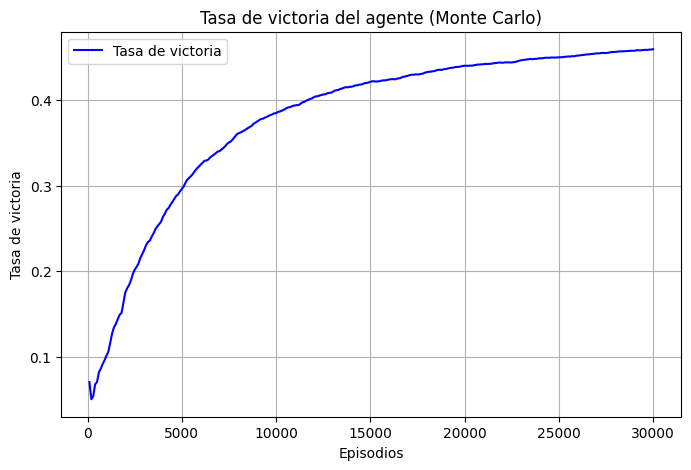

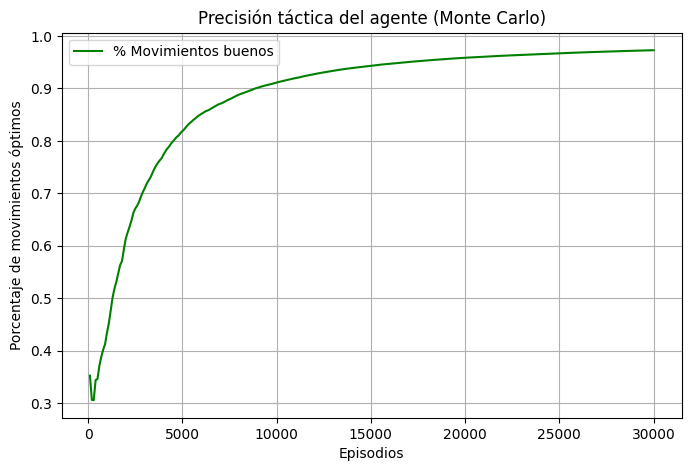

In [15]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# ----------------------------
# Parámetros del entorno
# ----------------------------
NUM_HEAPS = 3
MAX_HEAP_SIZE = 5
EPISODES = 30000
EPSILON_START = 1
EPSILON_MIN = 0.001
EPSILON_DECAY = 0.99

# ----------------------------
# Funciones auxiliares
# ----------------------------
def get_possible_actions(state):
    actions = []
    for i, heap in enumerate(state):
        for amt in range(1, heap + 1):
            actions.append((i, amt))
    return actions

def apply_action(state, action):
    heap_idx, remove_amt = action
    state = list(state)
    state[heap_idx] -= remove_amt
    return tuple(state)

def is_terminal(state):
    return all(heap == 0 for heap in state)

def choose_action(state, Q, epsilon):
    actions = get_possible_actions(state)
    if not actions:
        return None
    if random.random() < epsilon:
        return random.choice(actions)
    q_vals = [Q[(state, a)] for a in actions]
    max_q = max(q_vals)
    best_actions = [a for a, q in zip(actions, q_vals) if q == max_q]
    return random.choice(best_actions)

def xor_sum(state):
    result = 0
    for heap in state:
        result ^= heap
    return result

# ----------------------------
# Monte Carlo Entrenamiento
# ----------------------------
Q = defaultdict(float)
returns_count = defaultdict(int)
epsilon = EPSILON_START
win_counts = 0
win_rates = []
good_move_percentages = []

total_good_opportunities = 0
good_moves_made = 0

for episode in range(EPISODES):
    state = tuple(random.randint(1, MAX_HEAP_SIZE) for _ in range(NUM_HEAPS))
    episode_history = []
    player_turn = random.randint(0, 1)  # Empieza al azar

    while not is_terminal(state):
        if player_turn == 0:
            action = choose_action(state, Q, epsilon)
            if action is None:
                break

            xor_before = xor_sum(state)
            if xor_before != 0:
                if any(xor_sum(apply_action(state, a)) == 0 for a in get_possible_actions(state)):
                    total_good_opportunities += 1
                    if xor_sum(apply_action(state, action)) == 0:
                        good_moves_made += 1

            episode_history.append((state, action))
            state = apply_action(state, action)

            if is_terminal(state):
                reward = 1
                break
        else:
            actions = get_possible_actions(state)
            if not actions:
                break
            xor_before = xor_sum(state)

            if xor_before == 0:
                action = random.choice(actions)
            else:
                good_actions = [a for a in actions if xor_sum(apply_action(state, a)) == 0]
                if good_actions:
                    action = random.choice(good_actions)
                else:
                    action = random.choice(actions)
            state = apply_action(state, action)

            if is_terminal(state):
                reward = -1
                break
        player_turn = 1 - player_turn
    else:
        reward = 0  # empate, no debería pasar en Nim bien definido

    # Monte Carlo update (first-visit)
    visited = set()
    for i, (s, a) in enumerate(episode_history):
        if (s, a) in visited:
            continue
        visited.add((s, a))
        returns_count[(s, a)] += 1
        Q[(s, a)] += (reward - Q[(s, a)]) / returns_count[(s, a)]

    if reward == 1:
        win_counts += 1

    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    # Métricas cada 100 episodios
    if (episode + 1) % 100 == 0:
        win_rates.append(win_counts / (episode + 1))
        if total_good_opportunities == 0:
            good_move_percentages.append(0)
        else:
            good_move_percentages.append(good_moves_made / total_good_opportunities)

# ----------------------------
# Visualización
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), win_rates, label='Tasa de victoria', color='blue')
plt.xlabel("Episodios")
plt.ylabel("Tasa de victoria")
plt.title("Tasa de victoria del agente (Monte Carlo)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), good_move_percentages, label='% Movimientos buenos', color='green')
plt.xlabel("Episodios")
plt.ylabel("Porcentaje de movimientos óptimos")
plt.title("Precisión táctica del agente (Monte Carlo)")
plt.grid(True)
plt.legend()
plt.show()

